1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils import shuffle
#sns.set(rc = {'figure.figsize':(16,9)})
random_state = 12345
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from lifelines import CoxPHFitter

2. Import Datasets

In [2]:
# Read train data from IDA_2024
X_train = pd.read_csv("IDA_2024/train_operational_readouts.csv")
X_train_spec = pd.read_csv("IDA_2024/train_specifications.csv")
X_train_tte = pd.read_csv("IDA_2024/train_tte.csv")

Data Preprocessing

In [3]:
#Encoding Categorical data
spec_encoded = pd.get_dummies(X_train_spec)
spec_encoded = spec_encoded.replace({False: 0, True: 1}) 
categorical_col = spec_encoded.columns[1:]

#numerical features
numerical_col = X_train.columns[2:]

C:\Users\moka6903\AppData\Local\Temp\9\ipykernel_6784\1857747401.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spec_encoded = spec_encoded.replace({False: 0, True: 1})


Selecting last read out from operational dataset

In [4]:
# Select maximum cycle
max_cycle = X_train.groupby(by="vehicle_id")['time_step'].transform(max)
X_train_max_cycle = X_train[X_train["time_step"] == max_cycle].reset_index()
X_train_max_cycle.drop(columns='index', axis = 1, inplace= True)

C:\Users\moka6903\AppData\Local\Temp\9\ipykernel_6784\1431256340.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_cycle = X_train.groupby(by="vehicle_id")['time_step'].transform(max)


Merging all three train datasets

In [5]:
# merged Scania train dataset and lable dataset and spec dataset
df_train = pd.merge(X_train_tte , X_train_max_cycle , left_on='vehicle_id', right_on='vehicle_id')
dataset_merged=  pd.merge(df_train, spec_encoded , left_on='vehicle_id', right_on='vehicle_id')
dataset_merged.shape

(23550, 199)

Handeling missing Value by bfill

In [6]:
print('missing data in dataset:', dataset_merged.isna().sum().sum())
dataset_ffil = dataset_merged.bfill(axis = 0)
dataset_ffil.isna().sum().sum()

missing data in dataset: 11675


0

Creating RUL ans Status columns, necessary for lable sataset in survival analysis

In [7]:
# Create status column
dataset_ffil['status'] = dataset_ffil['in_study_repair'].apply(lambda x: False if x == 0 else True)
# Distribution of each status
print('X_train value_counts',dataset_ffil['status'].value_counts())
#creating RUL column
dataset_ffil['RUL'] = dataset_ffil['length_of_study_time_step'] - dataset_ffil['time_step']
print('Dataset Shape', dataset_ffil.shape)

X_train value_counts status
False    21278
True      2272
Name: count, dtype: int64
Dataset Shape (23550, 201)


Class distribution in time

features with Correlation with RUL< 0.01 are identified and removed

In [8]:
target_column = 'RUL'
df = dataset_ffil[list(numerical_col) + list(categorical_col) + ['RUL']].copy()
# Compute the correlation matrix
correlation_matrix = df.corrwith(df[target_column]).abs()

# Filter out correlations below the threshold
threshold = 0.01
filtered_correlations = correlation_matrix[correlation_matrix.abs() <= threshold]

# Sort the remaining correlations in ascending order
sorted_correlations = filtered_correlations.sort_values()
least_correlated_features = sorted_correlations.index.tolist()
# Print the least correlated features
print("Least correlated features:")
print(least_correlated_features, len(least_correlated_features))

dataset_droped_corr = dataset_ffil.drop(columns= least_correlated_features, inplace = False)
dataset_droped_corr.shape

Least correlated features:
['Spec_2_Cat5', 'Spec_7_Cat8', 'Spec_6_Cat10', 'Spec_1_Cat12', 'Spec_1_Cat19', 'Spec_1_Cat16', 'Spec_6_Cat13', 'Spec_2_Cat4', 'Spec_2_Cat13', '291_0', 'Spec_1_Cat24', 'Spec_1_Cat6', 'Spec_3_Cat2', '158_0', 'Spec_1_Cat15', 'Spec_1_Cat18', 'Spec_6_Cat18', 'Spec_2_Cat11', 'Spec_2_Cat15', 'Spec_1_Cat3', '397_23', '397_11', '397_28', '291_7', '397_22', '397_10', '397_29', 'Spec_6_Cat6', '397_9', 'Spec_6_Cat8', 'Spec_2_Cat20', 'Spec_1_Cat25', '397_4', '397_16', 'Spec_1_Cat4', 'Spec_5_Cat2', '291_8', '397_15', '291_9', 'Spec_1_Cat9', '397_21', '291_6', '397_12', 'Spec_1_Cat27', '291_1', '397_17', '459_17', '291_10', '291_2', 'Spec_3_Cat0', 'Spec_0_Cat0', '397_2', 'Spec_2_Cat7', 'Spec_2_Cat12', 'Spec_2_Cat3', 'Spec_1_Cat10', 'Spec_1_Cat23', '397_14', '459_19', 'Spec_6_Cat15', 'Spec_2_Cat18', 'Spec_5_Cat1', '397_7', 'Spec_1_Cat22', '397_3', '397_6', 'Spec_0_Cat1', 'Spec_1_Cat7', 'Spec_2_Cat19', 'Spec_2_Cat6', 'Spec_1_Cat11', '397_19', 'Spec_5_Cat0', 'Spec_5_Cat3', '39

(23550, 108)

Finding high correlation features

In [9]:

df2 = dataset_droped_corr.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id', 'status','RUL'], axis = 1)

# Define the correlation threshold
correlation_threshold = 0.90
correlation_matrix = df2.corr().abs()
# Get the upper triangle of the correlation matrix
upper_triangle = np.triu(correlation_matrix, k=1)

# Find the indices where the correlation exceeds the threshold
high_correlation_indices = np.where(upper_triangle > correlation_threshold)

# Initialize a list to store pairs of highly correlated variables
high_correlation_pairs = []
high_correlation_features = []
high_correlation_features_all = []

# Iterate through the indices and extract the variable pairs
for i, j in zip(high_correlation_indices[0], high_correlation_indices[1]):
    variable_i = correlation_matrix.index[i]
    variable_j = correlation_matrix.columns[j]
    correlation_value = correlation_matrix.iloc[i, j]
    high_correlation_features.append(variable_i)
    

print( list(set(high_correlation_features)))

['158_4', '459_4', '459_10', 'Spec_4_Cat0', '459_3', '459_5', '158_6', '291_4', '459_6', '397_8', '167_5', '158_8', '459_11', '397_1', '167_1', '171_0', '427_0', '397_20', '835_0', '158_5', '459_7', '459_9', '459_8', '459_2']


Heatmap of feature correlations

In [10]:
main_data1 = dataset_droped_corr.drop(columns= list(set(high_correlation_features)))
main_data =main_data1.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id'], axis = 1)
main_data

,666_0,837_0,167_0,167_2,167_3,167_4,167_6,167_7,167_8,167_9,...,Spec_6_Cat9,Spec_7_Cat0,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,status,RUL
0,372685.0,41670.0,10415.0,74655621.0,45991626.0,65888583.0,5813857.0,3351.0,0.0,0.0,...,0,1,0,0,0,0,0,0,False,2.6
1,289371.0,68717.0,10415.0,74655621.0,45991626.0,65888583.0,5813857.0,3351.0,0.0,0.0,...,0,0,1,0,0,0,0,0,False,0.8
2,230831.0,100121.0,5918.0,17004223.0,10504195.0,30792854.0,27370868.0,3819383.0,293456.0,101162.0,...,0,0,1,0,0,0,0,0,False,2.2
3,210381.0,152385.0,7128.0,13348382.0,11538870.0,30085352.0,53625651.0,1225967.0,7593.0,0.0,...,0,0,1,0,0,0,0,0,False,7.0
4,280531.0,164673.0,2688.0,13604867.0,14694395.0,41110339.0,15011017.0,689121.0,43760.0,13999.0,...,0,0,1,0,0,0,0,0,False,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23545,75859.0,10040.0,6631.0,10519563.0,8797533.0,27117757.0,6053328.0,32612.0,0.0,0.0,...,0,0,0,0,1,0,0,0,False,24.8
23546,138179.0,35726.0,15397.0,11640261.0,7568543.0,19594203.0,48183109.0,1682930.0,52639.0,0.0,...,0,0,0,0,1,0,0,0,False,1.4
23547,118371.0,9122.0,6783.0,6551850.0,6232055.0,17999988.0,12452989.0,108785.0,0.0,0.0,...,0,0,0,0,1,0,0,0,False,7.0
23548,80078.0,11251.0,755.0,16152271.0,7956861.0,17692205.0,9509643.0,483602.0,2240.0,0.0,...,0,0,0,0,1,0,0,0,False,0.2


Splitting data to 20/80

In [11]:
x_train, x_test, y_train, y_test = train_test_split(shuffle(main_data), main_data['status'], test_size=0.2, random_state= random_state,
                                                    stratify= main_data['status'])


In [12]:
# Preprocessing for target variable for train dataset

train_y = list(x_train.loc[:, ["status", "RUL"]].itertuples(index = None, name = None))
train_y = np.array(train_y, dtype=[('status', bool), ('RUL', float)])
train_X = x_train.drop(columns= ['RUL','status'], axis = 1)
train_X.shape

(18840, 78)

In [13]:
# Preprocessing for target variable for test dataset

test_y = list(x_test.loc[:, ["status", "RUL"]].itertuples(index = None, name = None))
test_y = np.array(test_y, dtype=[('status', bool), ('RUL', float)])
test_X = x_test.drop(columns= ['RUL','status'], axis = 1)
test_X.shape

(4710, 78)

Gradient Boosting SA

In [39]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=50,min_samples_split =30, min_samples_leaf =20,  learning_rate=0.5, max_depth=6, random_state=random_state)

In [40]:
est_cph_tree.fit(train_X, train_y)

GradientBoostingSurvivalAnalysis(learning_rate=0.5, max_depth=6,
                                 min_samples_leaf=20, min_samples_split=30,
                                 n_estimators=50, random_state=12345)

In [41]:
est_cph_tree.score(test_X, test_y)

0.716965608893513

In [42]:
est_cph_tree.score(train_X, train_y)

0.8378250394964338

RSF

In [14]:
# Create a RandomSurvivalForest model
rsf = RandomSurvivalForest(
    n_estimators=200, max_depth= 30, max_features='log2',  min_samples_split=30, min_samples_leaf=10, n_jobs = -1, random_state=random_state
)

In [15]:
rsf.fit(train_X, train_y)

RandomSurvivalForest(max_depth=30, max_features='log2', min_samples_leaf=10,
                     min_samples_split=30, n_estimators=200, n_jobs=-1,
                     random_state=12345)

In [44]:
rsf.fit(train_X, train_y)
#c-index evaluation metric
rsf.score(test_X, test_y)

0.7195483298433668

In [48]:
rsf.score(train_X, train_y)

0.943777222061914

COX

In [45]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
estimator = CoxPHSurvivalAnalysis()
estimator.fit(train_X, train_y)

\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.1534e-21): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=9.13853e-22): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.78378e-21): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=5.8676e-22): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.16762e-22): result may not be accurate.
  delta =

CoxPHSurvivalAnalysis()

In [46]:
estimator.score(test_X, test_y)

0.6875948083287068

In [47]:
estimator.score(train_X, train_y)

0.671009473650339

Comparing CPH to Permutation Importance analysis

        Variable   Coefficient
0          666_0 -1.700000e-07
1          837_0 -1.100000e-06
2          167_0 -2.100000e-06
3          167_2  2.000000e-08
4          167_3 -1.000000e-08
5          167_4 -0.000000e+00
6          167_6  0.000000e+00
7          167_7 -5.000000e-08
8          167_8  1.100000e-07
9          167_9 -6.000000e-08
10         309_0 -6.000000e-07
11         272_0 -4.000000e-08
12         272_1 -4.000000e-08
13         272_2 -0.000000e+00
14         272_3 -0.000000e+00
15         272_4 -0.000000e+00
16         272_5  0.000000e+00
17         272_6  2.000000e-07
18         272_7 -1.320000e-06
19         272_8  6.270000e-06
20         272_9 -1.243000e-05
21         370_0  0.000000e+00
22         291_3 -5.910000e-06
23         291_5 -2.663000e-05
24         158_1  1.000000e-08
25         158_2  0.000000e+00
26         158_3  1.000000e-08
27         158_7 -6.000000e-08
28         158_9  0.000000e+00
29         100_0  1.000000e-08
30         459_0 -2.682000e-05
31      

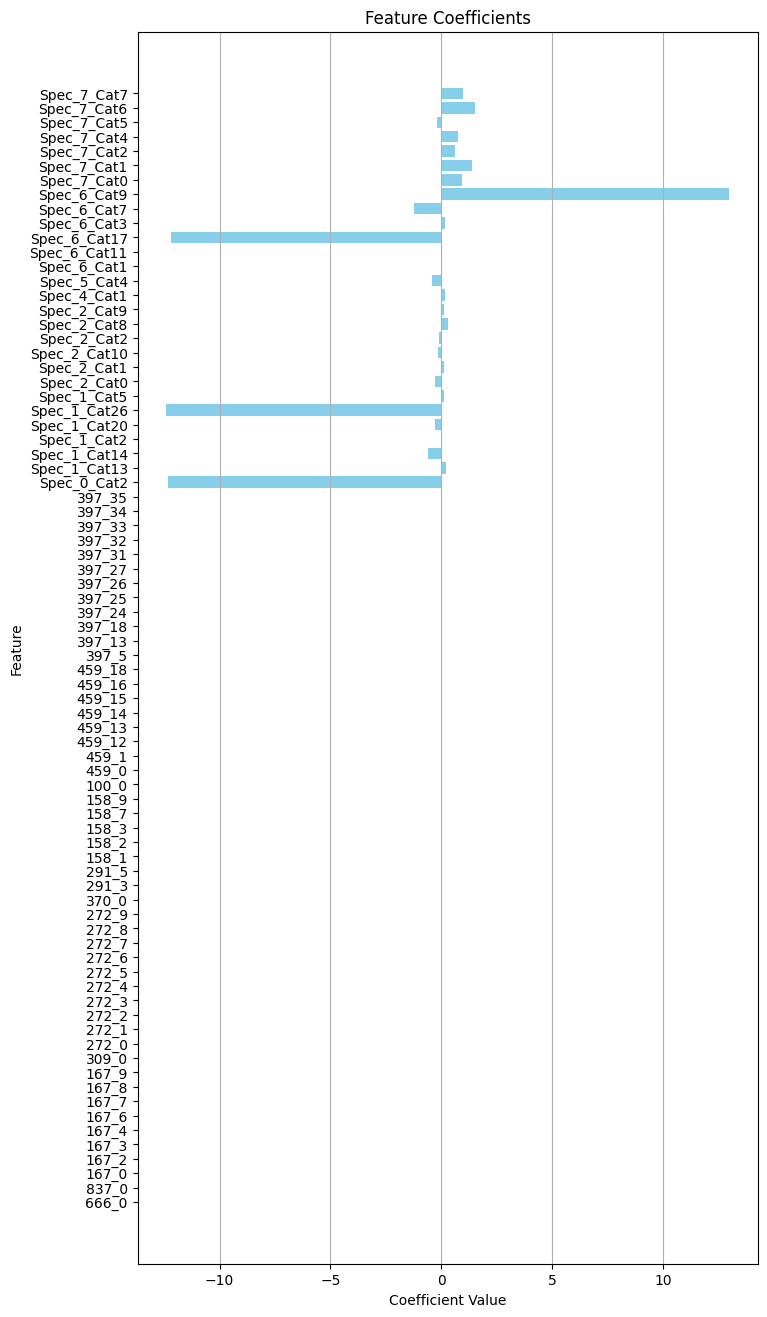

In [49]:
feature_importance = estimator.coef_.round(8)

coef_df = pd.DataFrame({"Variable": test_X.columns, "Coefficient": feature_importance})
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print(coef_df)
# Plot the coefficients
plt.figure(figsize=(8, 16))
plt.barh(coef_df['Variable'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.grid(axis='x')
plt.show()

In [16]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, test_X, test_y, n_repeats=10, random_state=random_state)
# Get the feature importances
importances = result.importances_mean

# Get the indices of the top 30 features with the highest absolute importances
top_indices = importances.argsort()[-60:][::-1]

# Get the corresponding feature names
top_features = test_X.columns[top_indices]

# Get the corresponding importances
top_importances = importances[top_indices]

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.bar(top_features, top_importances)
plt.title('Top 60 Features by Permutation Importance')
plt.xlabel('Feature')
plt.ylabel('Mean Permutation Importance')
plt.xticks(rotation=90)
plt.show()